In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision.utils as vutils
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

# A list of valid image file extensions
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png')

class CustomImageDataset(Dataset):
    """
    A custom dataset to load images from a list of specified class directories.
    This avoids the 'ImageFolder' error by not scanning the parent directory.
    """
    def __init__(self, class_dirs, transform=None):
        """
        Args:
            class_dirs (dict): A dictionary where keys are class names ('Normal', 'Ischemic')
                               and values are the full paths to the class directories.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.transform = transform
        self.class_dirs = class_dirs
        self.classes = list(class_dirs.keys())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = self._make_dataset()

    def _make_dataset(self):
        instances = []
        # Iterate through the dictionary of directories we provided
        for class_name, dir_path in self.class_dirs.items():
            class_idx = self.class_to_idx[class_name]
            if not os.path.isdir(dir_path):
                print(f"Warning: Directory not found, skipping: {dir_path}")
                continue

            # Find all valid image files in this specific directory
            for fname in sorted(os.listdir(dir_path)):
                if fname.lower().endswith(IMG_EXTENSIONS):
                    path = os.path.join(dir_path, fname)
                    item = (path, class_idx)
                    instances.append(item)
        return instances

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        # Open the image using PIL
        image = Image.open(path).convert('RGB')
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        return image, label

Using device: cuda

--- Dataset Loading Report ---
Classes loaded: ['Non-Ischaemic', 'Ischaemic', 'Hemoraj']
Total images found: 13333

Training set size (Normal scans only): 4427
Testing set size (Abnormal scans only): 8906

Displaying a sample batch to confirm data is loaded correctly...


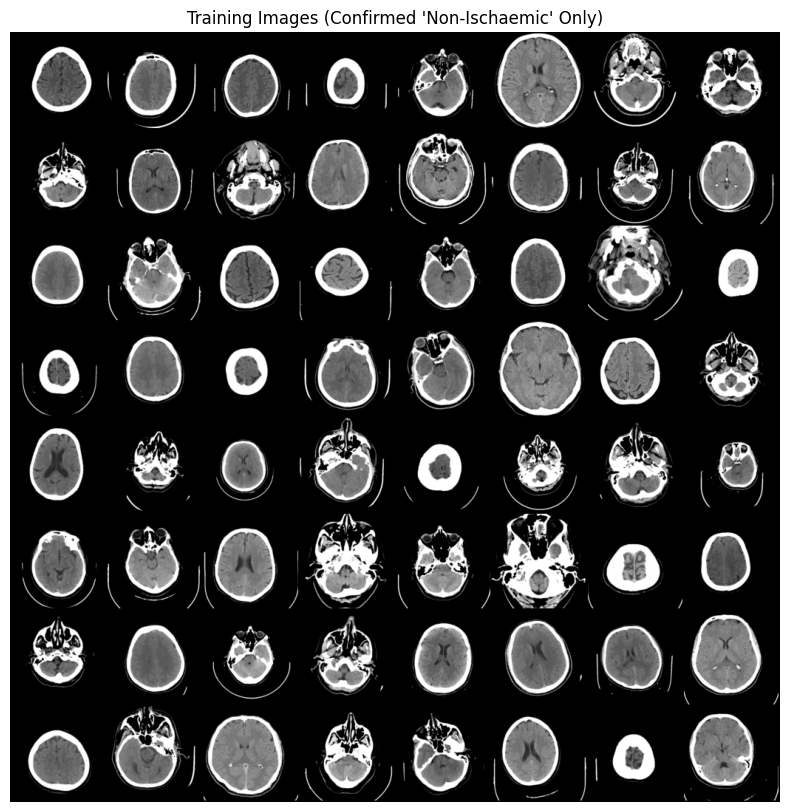

In [2]:
# Configuration and Device Setup 
# Define the base directory
base_dir = "/kaggle/input/deepstroke/DeepStroke1_Data"

# Define the paths to the folders we want to use
class_directories = {
    'Non-Ischaemic': os.path.join(base_dir, "Non-Ischaemic"),
    'Ischaemic': os.path.join(base_dir, "Ischaemic"),
    'Hemoraj': os.path.join(base_dir, "Hemoraj")
}

# Model and training parameters
IMAGE_SIZE = 128
CHANNELS_IMG = 3
LATENT_DIM = 100
BATCH_SIZE = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Transformations 
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Instantiate our Custom Dataset
full_dataset = CustomImageDataset(class_dirs=class_directories, transform=transform)

print("\n--- Dataset Loading Report ---")
print(f"Classes loaded: {full_dataset.classes}")
print(f"Total images found: {len(full_dataset)}")

# Get Indices and Create Subsets for Training and Testing 
# Get the index for each class from our custom dataset object
normal_idx = full_dataset.class_to_idx['Non-Ischaemic']
ischemic_idx = full_dataset.class_to_idx['Ischaemic']
hemorrhagic_idx = full_dataset.class_to_idx['Hemoraj']

# Get the list of indices for each category
normal_indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label == normal_idx]
abnormal_indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label in [ischemic_idx, hemorrhagic_idx]]

# Create the final datasets using Subsets
train_dataset = Subset(full_dataset, normal_indices)
test_dataset_abnormal = Subset(full_dataset, abnormal_indices)

# Create DataLoaders 
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader_abnormal = DataLoader(test_dataset_abnormal, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nTraining set size (Normal scans only): {len(train_dataset)}")
print(f"Testing set size (Abnormal scans only): {len(test_dataset_abnormal)}")

# Final Visual Confirmation 
print("\nDisplaying a sample batch to confirm data is loaded correctly...")
real_batch, _ = next(iter(train_dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images (Confirmed 'Non-Ischaemic' Only)")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [24]:
import torch.nn as nn

# Define a Function to Initialize Model Weights 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# --- 2. Build the NEW, MORE POWERFUL Generator ---
# This architecture has more layers and a different structure to give it more capacity.
class Generator(nn.Module):
    def __init__(self, latent_dim, channels_img):
        super(Generator, self).__init__()
        self.init_size = 16  # We will start with a 16x16 feature map
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 512 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2), # -> 32x32
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # -> 64x64
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # -> 128x128
            nn.Conv2d(128, channels_img, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        # Reshape the noise vector into a batch of feature maps
        out = self.l1(z)
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Discriminator Architecture 
class Discriminator(nn.Module):
    def __init__(self, channels_img):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels_img, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 8, 1, 0, bias=False), # Final conv layer to get to 1x1
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.net(input)


# Instantiate and Prepare Models for Multi-GPU
print("--- Initializing Models.. ---")
generator = Generator(LATENT_DIM, CHANNELS_IMG)
discriminator = Discriminator(CHANNELS_IMG)

generator.apply(weights_init)
discriminator.apply(weights_init)

generator.to(device)
discriminator.to(device)

if torch.cuda.device_count() > 1:
  print(f"Let's use {torch.cuda.device_count()} GPUs!")
  generator = nn.DataParallel(generator)
  discriminator = nn.DataParallel(discriminator)

print("--- Models Initialized ---")

print("\n--- Generator Architecture ---")
print(generator)
print("\n--- Discriminator Architecture ---")
print(discriminator)

--- Initializing Models.. ---
Let's use 2 GPUs!
--- Models Initialized ---

--- Generator Architecture ---
DataParallel(
  (module): Generator(
    (l1): Sequential(
      (0): Linear(in_features=100, out_features=131072, bias=True)
    )
    (conv_blocks): Sequential(
      (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Upsample(scale_factor=2.0, mode='nearest')
      (2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Upsample(scale_factor=2.0, mode='nearest')
      (6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2, inplace=True)
      (9): Upsample(scale_factor=2.0, mode='nearest')
      (10): Conv2d(128, 

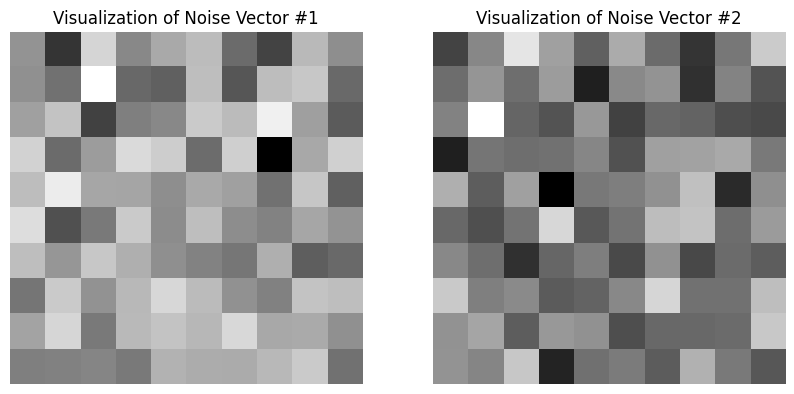

In [6]:
# Random noise visualization
import torch
import matplotlib.pyplot as plt
import numpy as np

# Use the same configuration as our main script
LATENT_DIM = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Let's create two different random noise vectors to compare ---
# Create a batch of 2 noise vectors. The shape is (batch_size, latent_dim, height, width)
# Use torch.randn to get values from a standard normal distribution.
noise = torch.randn(2, LATENT_DIM, 1, 1, device=device)

# Visualize the first noise vector 
noise_vector_1 = noise[0]

# To visualize, we must move it to the CPU and convert to a NumPy array.
# We also remove the extra 1x1 dimensions with .squeeze()
noise_numpy_1 = noise_vector_1.cpu().numpy().squeeze()

# Reshape the 100-element vector into a 10x10 grid
noise_image_1 = noise_numpy_1.reshape(10, 10)

# Visualize the second noise vector 
noise_vector_2 = noise[1]
noise_numpy_2 = noise_vector_2.cpu().numpy().squeeze()
noise_image_2 = noise_numpy_2.reshape(10, 10)


# Plot them side-by-side 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(noise_image_1, cmap='gray')
ax1.set_title("Visualization of Noise Vector #1")
ax1.axis('off')

ax2.imshow(noise_image_2, cmap='gray')
ax2.set_title("Visualization of Noise Vector #2")
ax2.axis('off')

plt.show()

In [7]:
import torch.optim as optim
import torchvision.utils as vutils
import time
import os

# Hyperparameters 
BATCH_SIZE = 256
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(f"DataLoader ready with Batch Size: {BATCH_SIZE}")

NUM_EPOCHS = 150 
LR_G = 0.0002
LR_D = 0.0002 
BETA1 = 0.5

# Setup 
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, LATENT_DIM, device=device) # Generator now takes a 1D vector

real_label = 0.9 # Keep label smoothing
fake_label = 0.

optimizerD = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(BETA1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=LR_G, betas=(BETA1, 0.999))

# The Main Training Loop 
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Advanced Training Loop...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_dataloader, 0):

        # Train Discriminator 
        discriminator.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)

        # Add noise to real images
        real_images = real_images + torch.randn_like(real_images, device=device) * 0.05
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, LATENT_DIM, device=device)
        fake_images = generator(noise)
        # Add noise to fake images
        fake_images_noisy = fake_images + torch.randn_like(fake_images, device=device) * 0.05
        label.fill_(fake_label)
        output = discriminator(fake_images_noisy.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train Generator 
        for _ in range(2):
            generator.zero_grad()
            label.fill_(real_label)
            # Re-generate fake images for this update
            noise = torch.randn(b_size, LATENT_DIM, device=device)
            fake_images = generator(noise)
            output = discriminator(fake_images).view(-1)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()
        D_G_z2 = output.mean().item()

        # Logging 
        if i % 10 == 0:
            elapsed_time = time.time() - start_time
            print(f'[{epoch+1}/{NUM_EPOCHS}][{i}/{len(train_dataloader)}] | Loss_D: {errD.item():.4f} | Loss_G: {errG.item():.4f} | '
                  f'D(x): {D_x:.4f} | D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f} | Time: {elapsed_time:.2f}s')

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 50 == 0) or ((epoch == NUM_EPOCHS-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake_samples = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_samples, padding=2, normalize=True))
        iters += 1

# Save Models 
os.makedirs("output", exist_ok=True)
torch.save(generator.state_dict(), 'output/generator_v2.pth')
torch.save(discriminator.state_dict(), 'output/discriminator_v2.pth')
print("\nTraining Finished. V2 Models saved to 'output/' directory.")

DataLoader ready with Batch Size: 256
Starting Advanced Training Loop...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return F.linear(input, self.weight, self.bias)


[1/150][0/18] | Loss_D: 2.7517 | Loss_G: 2.1070 | D(x): 0.6100 | D(G(z)): 0.6671 / 0.3023 | Time: 6.51s
[1/150][10/18] | Loss_D: 1.2229 | Loss_G: 2.0914 | D(x): 0.6908 | D(G(z)): 0.1494 / 0.2895 | Time: 19.41s
[2/150][0/18] | Loss_D: 13.5911 | Loss_G: 3.3125 | D(x): 0.9744 | D(G(z)): 0.9815 / 0.1278 | Time: 30.51s
[2/150][10/18] | Loss_D: 1.1587 | Loss_G: 1.8907 | D(x): 0.8057 | D(G(z)): 0.0747 / 0.2922 | Time: 43.66s
[3/150][0/18] | Loss_D: 1.3596 | Loss_G: 1.0541 | D(x): 0.5045 | D(G(z)): 0.0087 / 0.4843 | Time: 54.95s
[3/150][10/18] | Loss_D: 0.8771 | Loss_G: 1.9800 | D(x): 0.7488 | D(G(z)): 0.1146 / 0.1986 | Time: 68.55s
[4/150][0/18] | Loss_D: 1.1726 | Loss_G: 6.1282 | D(x): 0.9609 | D(G(z)): 0.2905 / 0.0029 | Time: 80.32s
[4/150][10/18] | Loss_D: 0.7400 | Loss_G: 0.7003 | D(x): 0.6905 | D(G(z)): 0.0537 / 0.6219 | Time: 94.51s
[5/150][0/18] | Loss_D: 1.2607 | Loss_G: 5.6638 | D(x): 0.9387 | D(G(z)): 0.3235 / 0.0131 | Time: 106.80s
[5/150][10/18] | Loss_D: 2.2238 | Loss_G: 2.4167 |

--- Starting Anomaly Detection Phase ---
Models loaded and set to evaluation mode.

Calculating anomaly scores for NORMAL images...
Processed batch 1 of normal images. Total normal tested: 50

Calculating anomaly scores for ABNORMAL images...
Processed batch 1 of abnormal images. Total abnormal tested: 50

--- Anomaly Detection Results ---


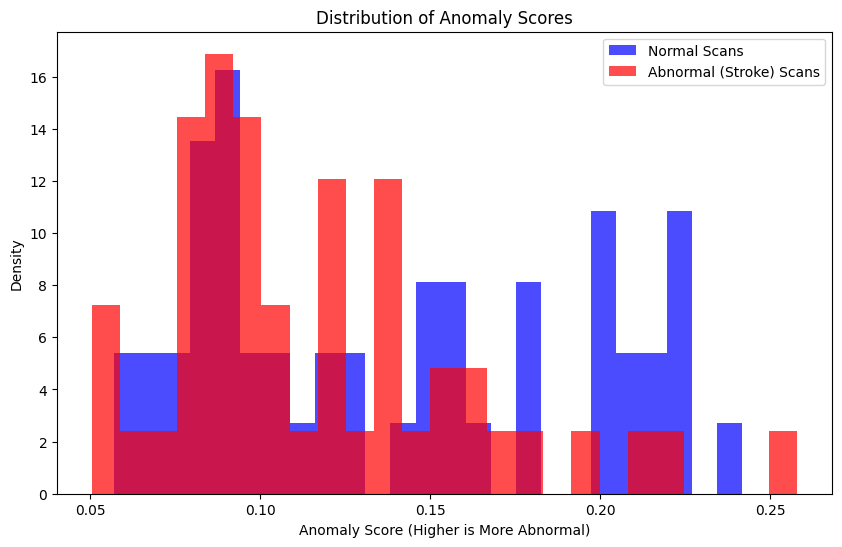


Visualizing some examples...


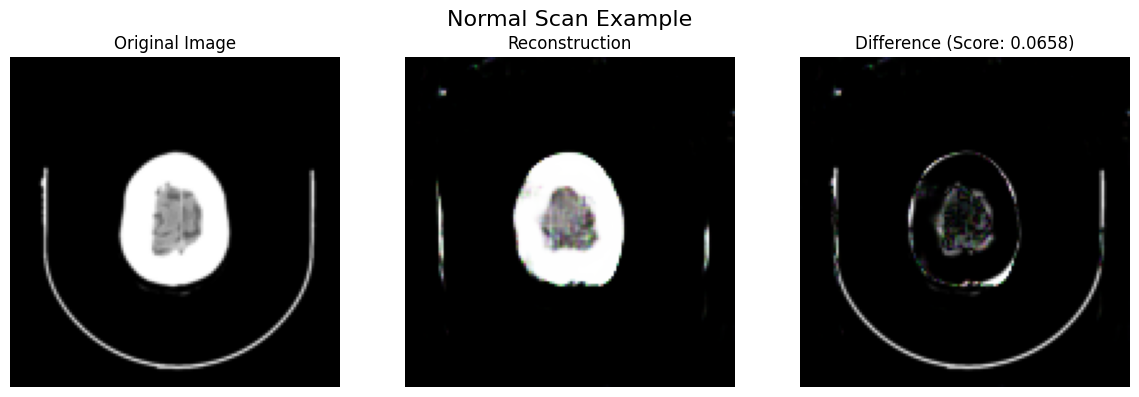

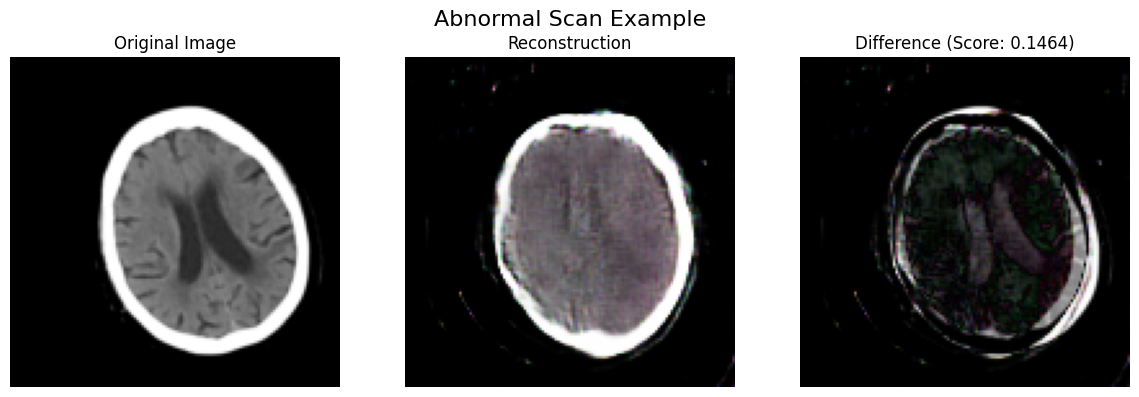

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

print("--- Starting Anomaly Detection Phase ---")

# Load the Trained Models 
# Re-initialize the model architectures
generator = Generator(LATENT_DIM, CHANNELS_IMG)
discriminator = Discriminator(CHANNELS_IMG)

# Use DataParallel to match the saved state_dict keys
use_dataparallel = torch.cuda.device_count() > 1
if use_dataparallel:
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)

# Load the saved weights
generator.load_state_dict(torch.load('output/generator_v2.pth'))
discriminator.load_state_dict(torch.load('output/discriminator_v2.pth'))

# Move models to the GPU and set to evaluation mode
generator.to(device)
discriminator.to(device)
generator.eval()
discriminator.eval()

print("Models loaded and set to evaluation mode.")

# Define the Anomaly Score Calculation 
def calculate_anomaly_score(input_image, generator, discriminator, latent_dim, lambda_val=0.1):
    z = torch.randn(input_image.size(0), latent_dim, device=device, requires_grad=True)
    z_optimizer = torch.optim.Adam([z], lr=0.01)

    residual_loss_fn = nn.L1Loss()
    discrimination_loss_fn = nn.L1Loss()

    for _ in range(150):
        z_optimizer.zero_grad()
        generated_image = generator(z)
        total_loss = residual_loss_fn(generated_image, input_image)
        total_loss.backward()
        z_optimizer.step()

    best_generated_image = generator(z)
    residual_loss = residual_loss_fn(best_generated_image, input_image).item()

    # Get the actual model from the DataParallel wrapper before accessing .net 
    # Get intermediate feature representation
    actual_discriminator = discriminator.module if use_dataparallel else discriminator

    # Now access .net through the actual_discriminator
    real_features = actual_discriminator.net[:4](input_image)
    fake_features = actual_discriminator.net[:4](best_generated_image)
    discrimination_loss = discrimination_loss_fn(fake_features, real_features).item()

    total_score = (1 - lambda_val) * residual_loss + lambda_val * discrimination_loss
    return total_score, best_generated_image


# Process the Test Datasets 
anomaly_scores = {'normal': [], 'abnormal': []}

print("\nCalculating anomaly scores for NORMAL images...")
# Limit to a few batches to save time 
normal_images_to_test = 50
count = 0
for i, (normal_images, _) in enumerate(train_dataloader):
    if count >= normal_images_to_test: break
    for image in normal_images:
        if count >= normal_images_to_test: break
        image = image.unsqueeze(0).to(device)
        score, _ = calculate_anomaly_score(image, generator, discriminator, LATENT_DIM)
        anomaly_scores['normal'].append(score)
        count += 1
    print(f"Processed batch {i+1} of normal images. Total normal tested: {count}")

print("\nCalculating anomaly scores for ABNORMAL images...")
# Limit to a few batches to save time 
abnormal_images_to_test = 50
count = 0
for i, (abnormal_images, _) in enumerate(test_dataloader_abnormal):
    if count >= abnormal_images_to_test: break
    for image in abnormal_images:
        if count >= abnormal_images_to_test: break
        image = image.unsqueeze(0).to(device)
        score, _ = calculate_anomaly_score(image, generator, discriminator, LATENT_DIM)
        anomaly_scores['abnormal'].append(score)
        count += 1
    print(f"Processed batch {i+1} of abnormal images. Total abnormal tested: {count}")


# Visualize the Results 
print("\n--- Anomaly Detection Results ---")

plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores['normal'], bins=25, alpha=0.7, label='Normal Scans', color='blue', density=True)
plt.hist(anomaly_scores['abnormal'], bins=25, alpha=0.7, label='Abnormal (Stroke) Scans', color='red', density=True)
plt.xlabel("Anomaly Score (Higher is More Abnormal)")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Anomaly Scores")
plt.show()

print("\nVisualizing some examples...")

def plot_reconstruction(dataloader, title):
    # Make sure we have data in the dataloader
    try:
        images, _ = next(iter(dataloader))
    except StopIteration:
        print(f"Dataloader for '{title}' is empty. Cannot generate plot.")
        return

    image_to_test = images[0].unsqueeze(0).to(device)
    score, reconstructed_image = calculate_anomaly_score(image_to_test, generator, discriminator, LATENT_DIM)

    # De-normalize image for plotting
    original_img_plot = np.transpose(images[0].cpu(), (1, 2, 0)) * 0.5 + 0.5
    reconstructed_img_plot = np.transpose(reconstructed_image.squeeze().detach().cpu(), (1, 2, 0)) * 0.5 + 0.5

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(title, fontsize=16)

    axes[0].imshow(original_img_plot)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(reconstructed_img_plot)
    axes[1].set_title(f"Reconstruction")
    axes[1].axis("off")

    # Calculate and show the difference map (residual)
    diff_map = np.abs(original_img_plot - reconstructed_img_plot)
    axes[2].imshow(diff_map.squeeze(), cmap='hot')
    axes[2].set_title(f"Difference (Score: {score:.4f})")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

plot_reconstruction(train_dataloader, "Normal Scan Example")
plot_reconstruction(test_dataloader_abnormal, "Abnormal Scan Example")